In [1]:
!pip install pandas numpy matplotlib seaborn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")  # Seaborn varsayılanlarını bozma
sns.set(rc={"figure.dpi": 110})


In [2]:
!bunzip2 -c /kaggle/input/amazonreviews/test.ft.txt.bz2 \
  > /kaggle/working/test.ft.txt


In [3]:
import bz2, itertools


DATA_PATH = "/kaggle/working/test.ft.txt" 

def read_fasttext(path: str) -> pd.DataFrame:
    """
    fastText formatındaki satırları ( '__label__X <metin>' ) 
    Pandas DataFrame'e dönüştürür.
    
    Parameters
    ----------
    path : str
        .txt veya .bz2 dosya yolu.
    
    Returns
    -------
    pd.DataFrame
        Kolonlar: 'label' (0=negatif, 1=pozitif), 'text'
    """
    open_fn = bz2.open if path.endswith(".bz2") else open
    labels, texts = [], []

    with open_fn(path, mode="rt", encoding="utf-8", errors="ignore") as f:
        for line in f: # max_rows ve itertools.islice kaldırıldı
            parts = line.rstrip("\n").split(" ", 1)
            if len(parts) != 2: # bozuk / boş satır
                continue
            lab, txt = parts
            labels.append(1 if lab == "__label__2" else 0) # 1=pozitif, 0=negatif
            texts.append(txt)

    return pd.DataFrame({"label": labels, "text": texts})

In [4]:
df = read_fasttext(DATA_PATH)
df.head()

,label,text
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   400000 non-null  int64 
 1   text    400000 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [6]:

na_report = df.isna().sum()
total_na  = int(na_report.sum())

if total_na == 0:
    print("Hiç eksik değer bulunmadı.")
else:
    print(f"Toplam {total_na} eksik değer tespit edildi:\n{na_report[na_report > 0]}")

# duplicate
dup_mask = df.duplicated(subset="text")
n_dups   = int(dup_mask.sum())

print("\nDuplicate Kontrolü")
if n_dups == 0:
    print("Duplicate satır bulunmadı.")
else:
    print(f"{n_dups} duplicate yorum metni bulundu; kayıtlar kaldırılıyor.")
    df = df.drop_duplicates(subset="text").reset_index(drop=True)
    print(f"Temizlik sonrası satır sayısı: {len(df):,}")

print("\nVeri Kümesi Boyutu:", len(df))
print("Sınıf Dağılımı (%):")
print(df['label']
      .value_counts(normalize=True)
      .mul(100)
      .round(2))


Hiç eksik değer bulunmadı.

Duplicate Kontrolü
Duplicate satır bulunmadı.

Veri Kümesi Boyutu: 400000
Sınıf Dağılımı (%):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


In [7]:
df["word_cnt"] = df["text"].str.split().str.len()
df["char_cnt"] = df["text"].str.len()


In [8]:
df[["word_cnt", "char_cnt"]].describe()

,word_cnt,char_cnt
count,400000.000000,400000.000000
mean,78.424145,431.429630
std,42.798609,237.435383
min,6.000000,99.000000
25%,42.000000,231.000000
50%,70.000000,383.000000
75%,108.000000,595.000000
max,230.000000,1015.000000


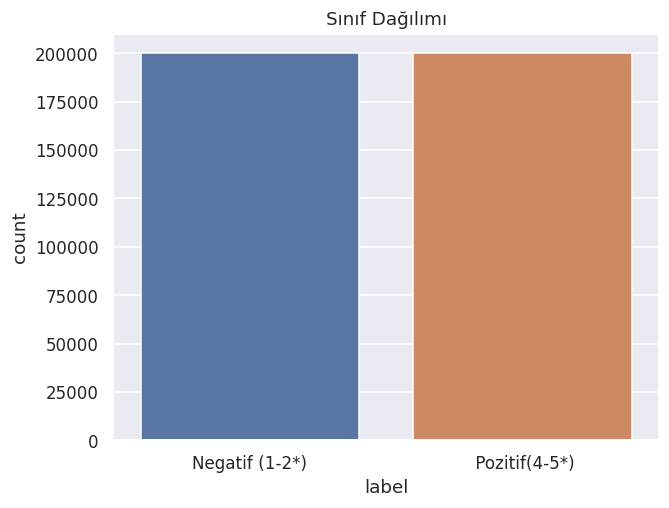

In [9]:
sns.countplot(x="label", data=df)
plt.xticks([0,1],["Negatif (1-2*)"," Pozitif(4-5*)"])
plt.title("Sınıf Dağılımı")
plt.show()

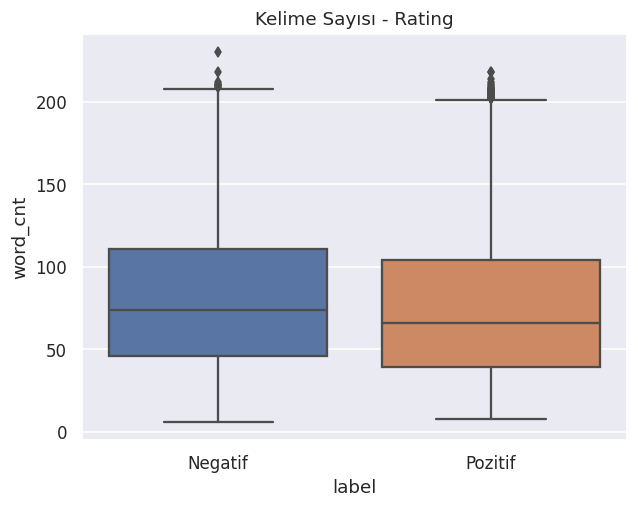

In [10]:
sns.boxplot(x="label",y="word_cnt",data=df)
plt.xticks([0,1],["Negatif","Pozitif"])
plt.title("Kelime Sayısı - Rating")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


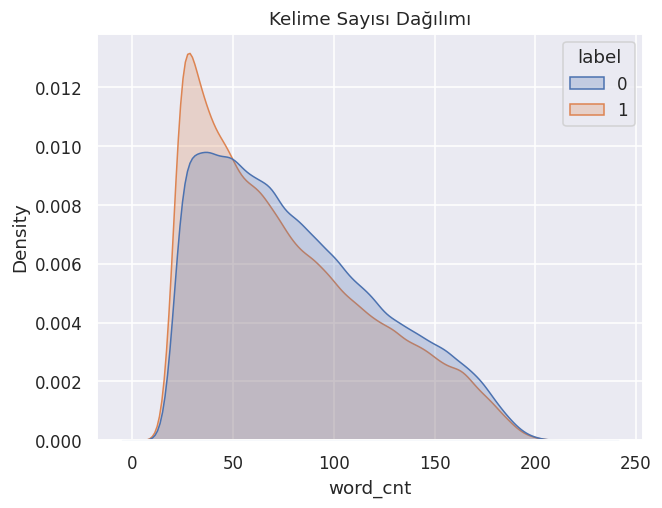

In [11]:
sns.kdeplot(data=df, x ="word_cnt", hue="label" , common_norm=False, fill=True)
plt.title("Kelime Sayısı Dağılımı")
plt.show()

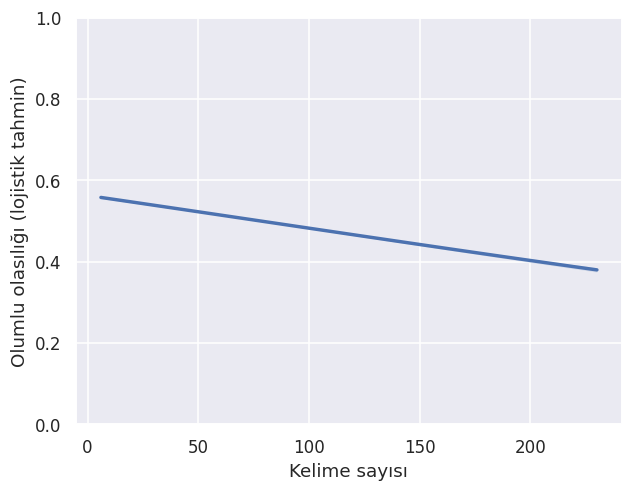

In [12]:
# 2) Ham dağılımı göstermeden sadece lojistik fit
sns.regplot(x="word_cnt", y="label", data=df,
            logistic=True, scatter=False)     # scatter=False gizler noktaları
plt.xlabel("Kelime sayısı")
plt.ylabel("Olumlu olasılığı (lojistik tahmin)")
plt.ylim(0, 1)
plt.show()


In [13]:
rho = df[["label", "word_cnt"]].corr(method="spearman").iloc[0, 1]
print(f"Spearman rho(label, word_cnt) = {rho:.3f}")

Spearman rho(label, word_cnt) = -0.078


## 
- **Spearman ρ**(kelime sayısı, label) = **–0.078**  
  - 0’a çok yakın ⇒ ilişki zayıf.  
- Lojistik regresyon eğrisi ↘︎ negatif; kelime sayısı arttıkça pozitif olma olasılığı çok hafif azalıyor.



1. Veri kümesi dengeli 
2. Negatif yorumlar ortalama biraz daha uzun görünse de dağılımlar büyük ölçüde çakışıyor.  
3. Kelime sayısı, duygu etiketini açıklamada istatistiksel olarak zayıf kalıyor (ρ≈–0.08).


##
Spearman ρ (rho), istatistikte Spearman Sıra Korelasyon Katsayısı olarak bilinen ve iki değişken arasındaki ilişkinin gücünü ve yönünü ölçen parametrik olmayan bir istatistiksel ölçüdür. Pearson korelasyon katsayısının aksine, Spearman ρ verilerin normal dağılım göstermesi varsayımını gerektirmez ve doğrusal olmayan, ancak monotonik ilişkileri değerlendirmek için daha uygundur.

Sıralı Verilerle Çalışır: Spearman ρ, verilerin kendisiyle değil, verilerin sıralamalarıyla çalışır. Yani, her bir değişkendeki değerler küçükten büyüğe (veya büyükten küçüğe) sıralanır ve bu sıralamalar arasındaki farklar analiz edilir. Bu, özellikle ordinal (sıralı) ölçekte ölçülmüş veriler veya sayısal olup normal dağılıma uymayan veriler için çok kullanışlıdır.

Monotonik İlişkiyi Ölçer: Monotonik ilişki, bir değişken arttığında diğer değişkenin ya sürekli artması ya da sürekli azalması anlamına gelir. İlişkinin doğrusal olması şart değildir. Örneğin, bir öğrencinin ders çalışma süresi arttıkça notlarının da artması (doğrusal olmasa bile), monotonik bir ilişkidir.

Değer Aralığı: Spearman ρ değeri -1 ile +1 arasında değişir:

+1: Mükemmel pozitif monotonik ilişki. Bir değişkenin sıralaması arttıkça, diğer değişkenin sıralaması da aynı yönde mükemmel bir şekilde artar.

-1: Mükemmel negatif monotonik ilişki. Bir değişkenin sıralaması arttıkça, diğer değişkenin sıralaması ters yönde mükemmel bir şekilde azalır.

0: Değişkenler arasında monotonik bir ilişki yoktur. Sıralamalar rastgele dağılmıştır